In [1]:
# In order to force the reload of modules
%load_ext autoreload
%autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import heapq
import numpy as np
from typing import *

from ml.rl.core import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
"""
Showing information about the environment
"""


with gym.make("MountainCar-v0") as env:
    print("observation shape:", env.reset().shape)
    print("action space:", {env.action_space.sample() for _ in range(100)})

observation shape: (2,)
action space: {0, 1, 2}


In [3]:
def try_agent(agent: Agent):
    with gym.make("MountainCar-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print("Total reward {0:.2f}".format(total_reward))

In [4]:
"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


try_agent(RandomAgent())

Total reward -200.00


Mean score: -200.0
Mean score: -200.0
Mean score: -200.0
Mean score: -200.0
Mean score: -200.0
Mean score: -200.0
Mean score: -200.0
Mean score: -200.0
Mean score: -200.0
Mean score: -200.0


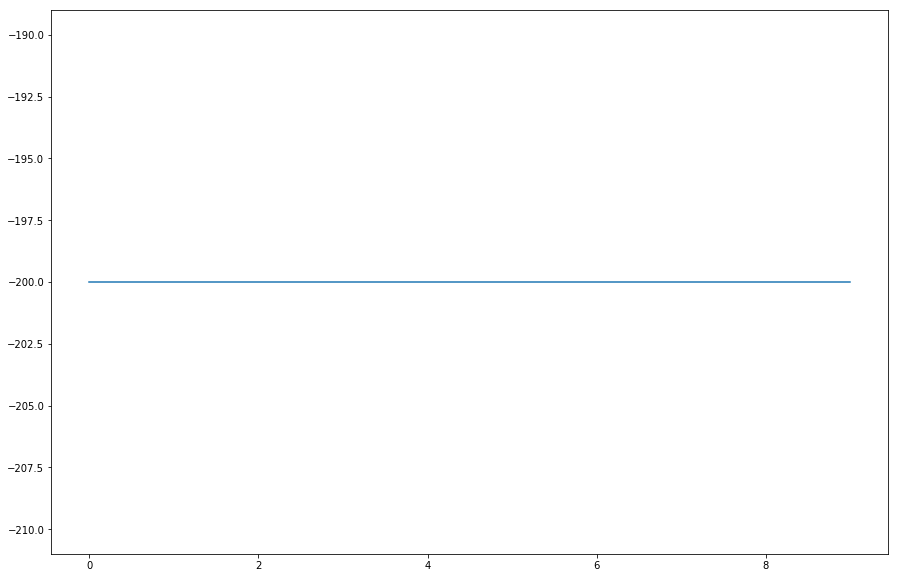

In [5]:
"""
Cross Entropy Method:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)
=> Look like a kind of genetic algorithm stuff
"""


from ml.rl.cross_entropy_method import *


"""
Implementation of a policy to learn via a Neural Net
"""


class FullyConnectedNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys


"""
Test with the policy of a neural net

=> Note it will NEVER PROGRESS since random policy does not produce a working example to learn from
"""


fc_net = FullyConnectedNet(observation_size=2, hidden_size=100, action_size=3)
policy = NeuralNetPolicy(iteration_nb=5, learning_rate=0.1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("MountainCar-v0") as env:
    scores = agent.fit(env, max_iteration=10, batch_size=16, batch_threshold=0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

In [6]:
"""
With Deep Q-Learning
"""


from ml.rl.deep_q_learning import *


class RegressionNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))

    def forward(self, observations):
        ys = self.fc(observations)
        return ys

    
"""
Try the Deep Q learning agent
"""


start_epsilon = 0.3
end_epsilon = 0.1

policy_net=RegressionNet(2, 200, 3)

agent = DeepQLearningAgent(
    q_values=NeuralNetQValues(net=policy_net, iteration_nb=10, learning_rate=1e-3),
    start_epsilon=start_epsilon,
    min_epsilon=end_epsilon)

with gym.make("MountainCar-v0") as env:
    max_iterations = 100
    scores = agent.fit(env,
                       is_success = lambda score: score > -200,
                       max_episodes = 10_000,
                       replay_buffer_size = 100,
                       replay_start_size = 100,
                       batch_size = 16,
                       policy_improvement_size = 50,
                       epsilon_decrease_factor = 0.99)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

# 50 Mean score: -200.0 (epsilon: 0.3 )
# 100 Mean score: -200.0 (epsilon: 0.3 )
# 150 Mean score: -200.0 (epsilon: 0.3 )
# 200 Mean score: -200.0 (epsilon: 0.3 )
# 250 Mean score: -200.0 (epsilon: 0.3 )
# 300 Mean score: -200.0 (epsilon: 0.3 )
# 350 Mean score: -200.0 (epsilon: 0.3 )
# 400 Mean score: -200.0 (epsilon: 0.3 )
# 450 Mean score: -200.0 (epsilon: 0.3 )
# 500 Mean score: -200.0 (epsilon: 0.3 )
# 550 Mean score: -200.0 (epsilon: 0.3 )
# 600 Mean score: -200.0 (epsilon: 0.3 )
# 650 Mean score: -200.0 (epsilon: 0.3 )
# 700 Mean score: -200.0 (epsilon: 0.3 )
# 750 Mean score: -200.0 (epsilon: 0.3 )
# 800 Mean score: -200.0 (epsilon: 0.3 )
# 850 Mean score: -200.0 (epsilon: 0.3 )
# 900 Mean score: -200.0 (epsilon: 0.3 )
# 950 Mean score: -200.0 (epsilon: 0.3 )
# 1000 Mean score: -200.0 (epsilon: 0.3 )
# 1050 Mean score: -200.0 (epsilon: 0.3 )
# 1100 Mean score: -200.0 (epsilon: 0.3 )
# 1150 Mean score: -200.0 (epsilon: 0.3 )
# 1200 Mean score: -200.0 (epsilon: 0.3 )
# 1250 Mean 

KeyboardInterrupt: 